In [31]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

gaia = Table.read('Gaia.vot')

Convert to pandas and inspect

In [32]:
# load the data to the pandas dataframe
import pandas as pd
df = gaia.to_pandas()
df.head()


,ra,dec,parallax,parallax_error,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,radial_velocity,radial_velocity_error,l,b
0,235.210639,-75.473087,0.189616,0.024176,-5.310136,-3.329038,12.836737,13.770793,11.897108,0.414605,0.672070,313.058982,-16.046951
1,246.404137,15.035012,3.208649,0.078680,-13.387038,-3.750262,11.661827,11.958838,11.193132,-43.597626,0.758399,30.661481,38.977174
2,294.739961,34.312760,0.351728,0.026255,-0.872637,-6.209009,12.918020,13.580598,12.147714,21.996602,0.671250,68.558197,6.067830
3,269.133379,-13.517191,0.455662,0.032030,-1.647247,-4.513978,13.561970,14.860425,12.432927,-47.240378,0.366152,14.585552,5.667024
4,237.769431,-75.513386,0.795595,0.023005,-15.195014,-16.791597,12.819647,13.383797,12.126850,-86.816011,0.579865,313.545296,-16.487915


Convert to radiant and select on the galactic plane

In [33]:
bMax = 5
df = df.loc[(df['b'] >= -bMax) & (df['b'] <= bMax)]

df['l'] = np.deg2rad(df['l'])

Usefull quantities and constants

In [34]:
# distance from the center of the galaxy
R = 8300

########################################################################
# cos and sin of longitude
df['cosl'] = np.cos(df['l'])
df['sinl'] = np.sin(df['l'])

########################################################################
# distance from the sun
df['d'] = 1000 / df['parallax']

########################################################################
# distance from galactic centre
df['D'] = np.sqrt( df['d']**2 + R**2 - 2*df['d']*R*df['cosl'])

########################################################################
# cos and sin of phi (angle from galactic center)
# df['cosphi'] = (df['d'] * df['cosl'] - R) / df['D'] 
# df['sinphi'] = (df['d'] * df['sinl']) / df['D']

##########################################################################


Error propagation (from the parallax)

In [35]:
########################################################################
# Parallax to distance
df['sigmad'] = 1000 * df['parallax_error'] / (df['parallax']**2)

########################################################################
# distance to sin and cos phi
# NOTE: sin and cos phi are not independant, and the error of the distance should be propagated all at once

# derivatives wrt distance
# df['DER_cosphi'] = R * df['d'] * (df['sinl']**2) / (df['D']**3)
# df['DER_sinphi'] = - R * df['cosphi'] * df['sinl'] / (df['D']**2)

df['DER_1/D'] = -df['sinl'] * R * (df['d'] - R*df['cosl']) / (df['D']**3)

# squared derivative of vmodel wrt distance without vrot**2, which is a parameter
# old implementation with angles
# df['DER2_Prop_model'] = (df['sigmad']*(df['cosl'] * df['DER_sinphi'] - df['sinl'] * df['DER_cosphi']))**2 

df['DER2_Prop_model'] = (df['sigmad'] * df['DER_1/D'])**2

# variance associated to radial velocitu
df['VAR_rad_vel'] = df['radial_velocity_error']**2

## Statistical model

In [36]:
def v_mod(par, sinl, cosl, D):
    vrot, u, v, VarIntrinsic = par
    return vrot*sinl*((R/D)-1) - u*cosl - v*sinl

def log_like(par, vrad, var_vrad, prop, sinl, cosl, D):
    vrot, u, v, VarIntrinsic = par
    return -0.5*( np.sum( ((vrad - v_mod(par, sinl, cosl, D))**2)/(var_vrad + (vrot**2)*prop + VarIntrinsic**2) + np.log(var_vrad + (vrot**2)*prop +VarIntrinsic**2) ) )

#tipical star motion in galaxies
vgal=200

# interval where the prior is defined and different from 0
Vmin = -500
Vmax = 500

MinVarIntrinsic = 0.1
MaxVarIntrinsic = 1000000

# log prior
def log_prior(par):
    vrot,u,v, VarIntrinsic=par
    if not Vmin<=vrot<=Vmax:
        return -np.inf
    if not Vmin<=u<=Vmax:
        return -np.inf
    if not Vmin<=v<=Vmax:
        return -np.inf

    if not MinVarIntrinsic<=VarIntrinsic<=MaxVarIntrinsic:
        return -np.inf

    return -(0.5*(u**2+v**2)/vgal**2) - np.log(VarIntrinsic)
    #return -(0.5*(u**2+v**2)/vgal**2)

# log prob
def log_prob(par,vrad,var_vrad,prop,sinl,cosl,D):
    lp=log_prior(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like(par,vrad,var_vrad,prop,sinl,cosl,D)


### demo of distribution for a set or parameters

Fit Parameters: mu = 0.92, var = 954.45
LogPrior: -6.85
LogLike: -517752.20
LogProb: -517759.05
Average varrad: 2.93
Average prop*vrot**2: 7.89


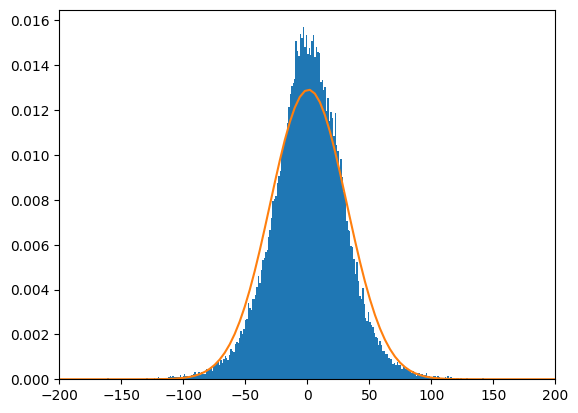

In [37]:
VrotTry = 205
uTry = 11.7
vTry = 22

VarIntrinsicTry = 937

df['vModTry'] = v_mod([VrotTry, uTry, vTry, VarIntrinsicTry], df['sinl'], df['cosl'], df['D'])

plt.hist(df['vModTry']-df['radial_velocity'], bins=1000, density=True);
plt.xlim(-200, 200)


mu, sigma = norm.fit(df['vModTry']-df['radial_velocity'])
plt.plot(np.linspace(-200, 200, 100), norm.pdf(np.linspace(-200, 200, 100), mu, sigma))

print("Fit Parameters: mu = {:.2f}, var = {:.2f}".format(mu, sigma**2))
print("LogPrior: {:.2f}".format(log_prior([VrotTry, uTry, vTry, VarIntrinsicTry])))
print("LogLike: {:.2f}".format(log_like([VrotTry, uTry, vTry, VarIntrinsicTry], df['radial_velocity'], df['VAR_rad_vel'], df['DER2_Prop_model'], df['sinl'], df['cosl'], df['D'])))
print("LogProb: {:.2f}".format(log_prob([VrotTry, uTry, vTry, VarIntrinsicTry], df['radial_velocity'], df['VAR_rad_vel'], df['DER2_Prop_model'], df['sinl'], df['cosl'], df['D'])))
print("Average varrad: {:.2f}".format(np.mean(df['VAR_rad_vel'])))
print("Average prop*vrot**2: {:.2f}".format(np.mean(df['DER2_Prop_model'])*VrotTry**2))

## Demo of the distribution of differences (our random variable) as a function of the distance from the galactic center

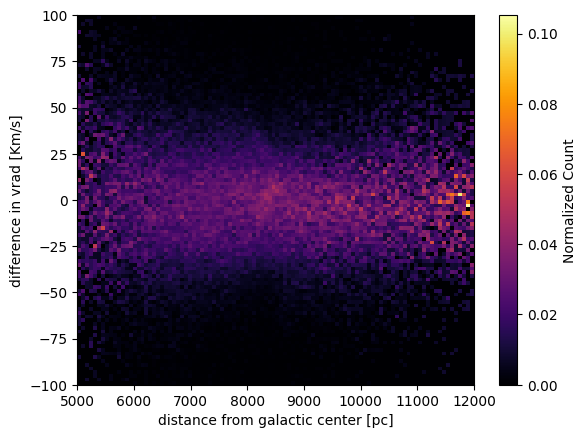

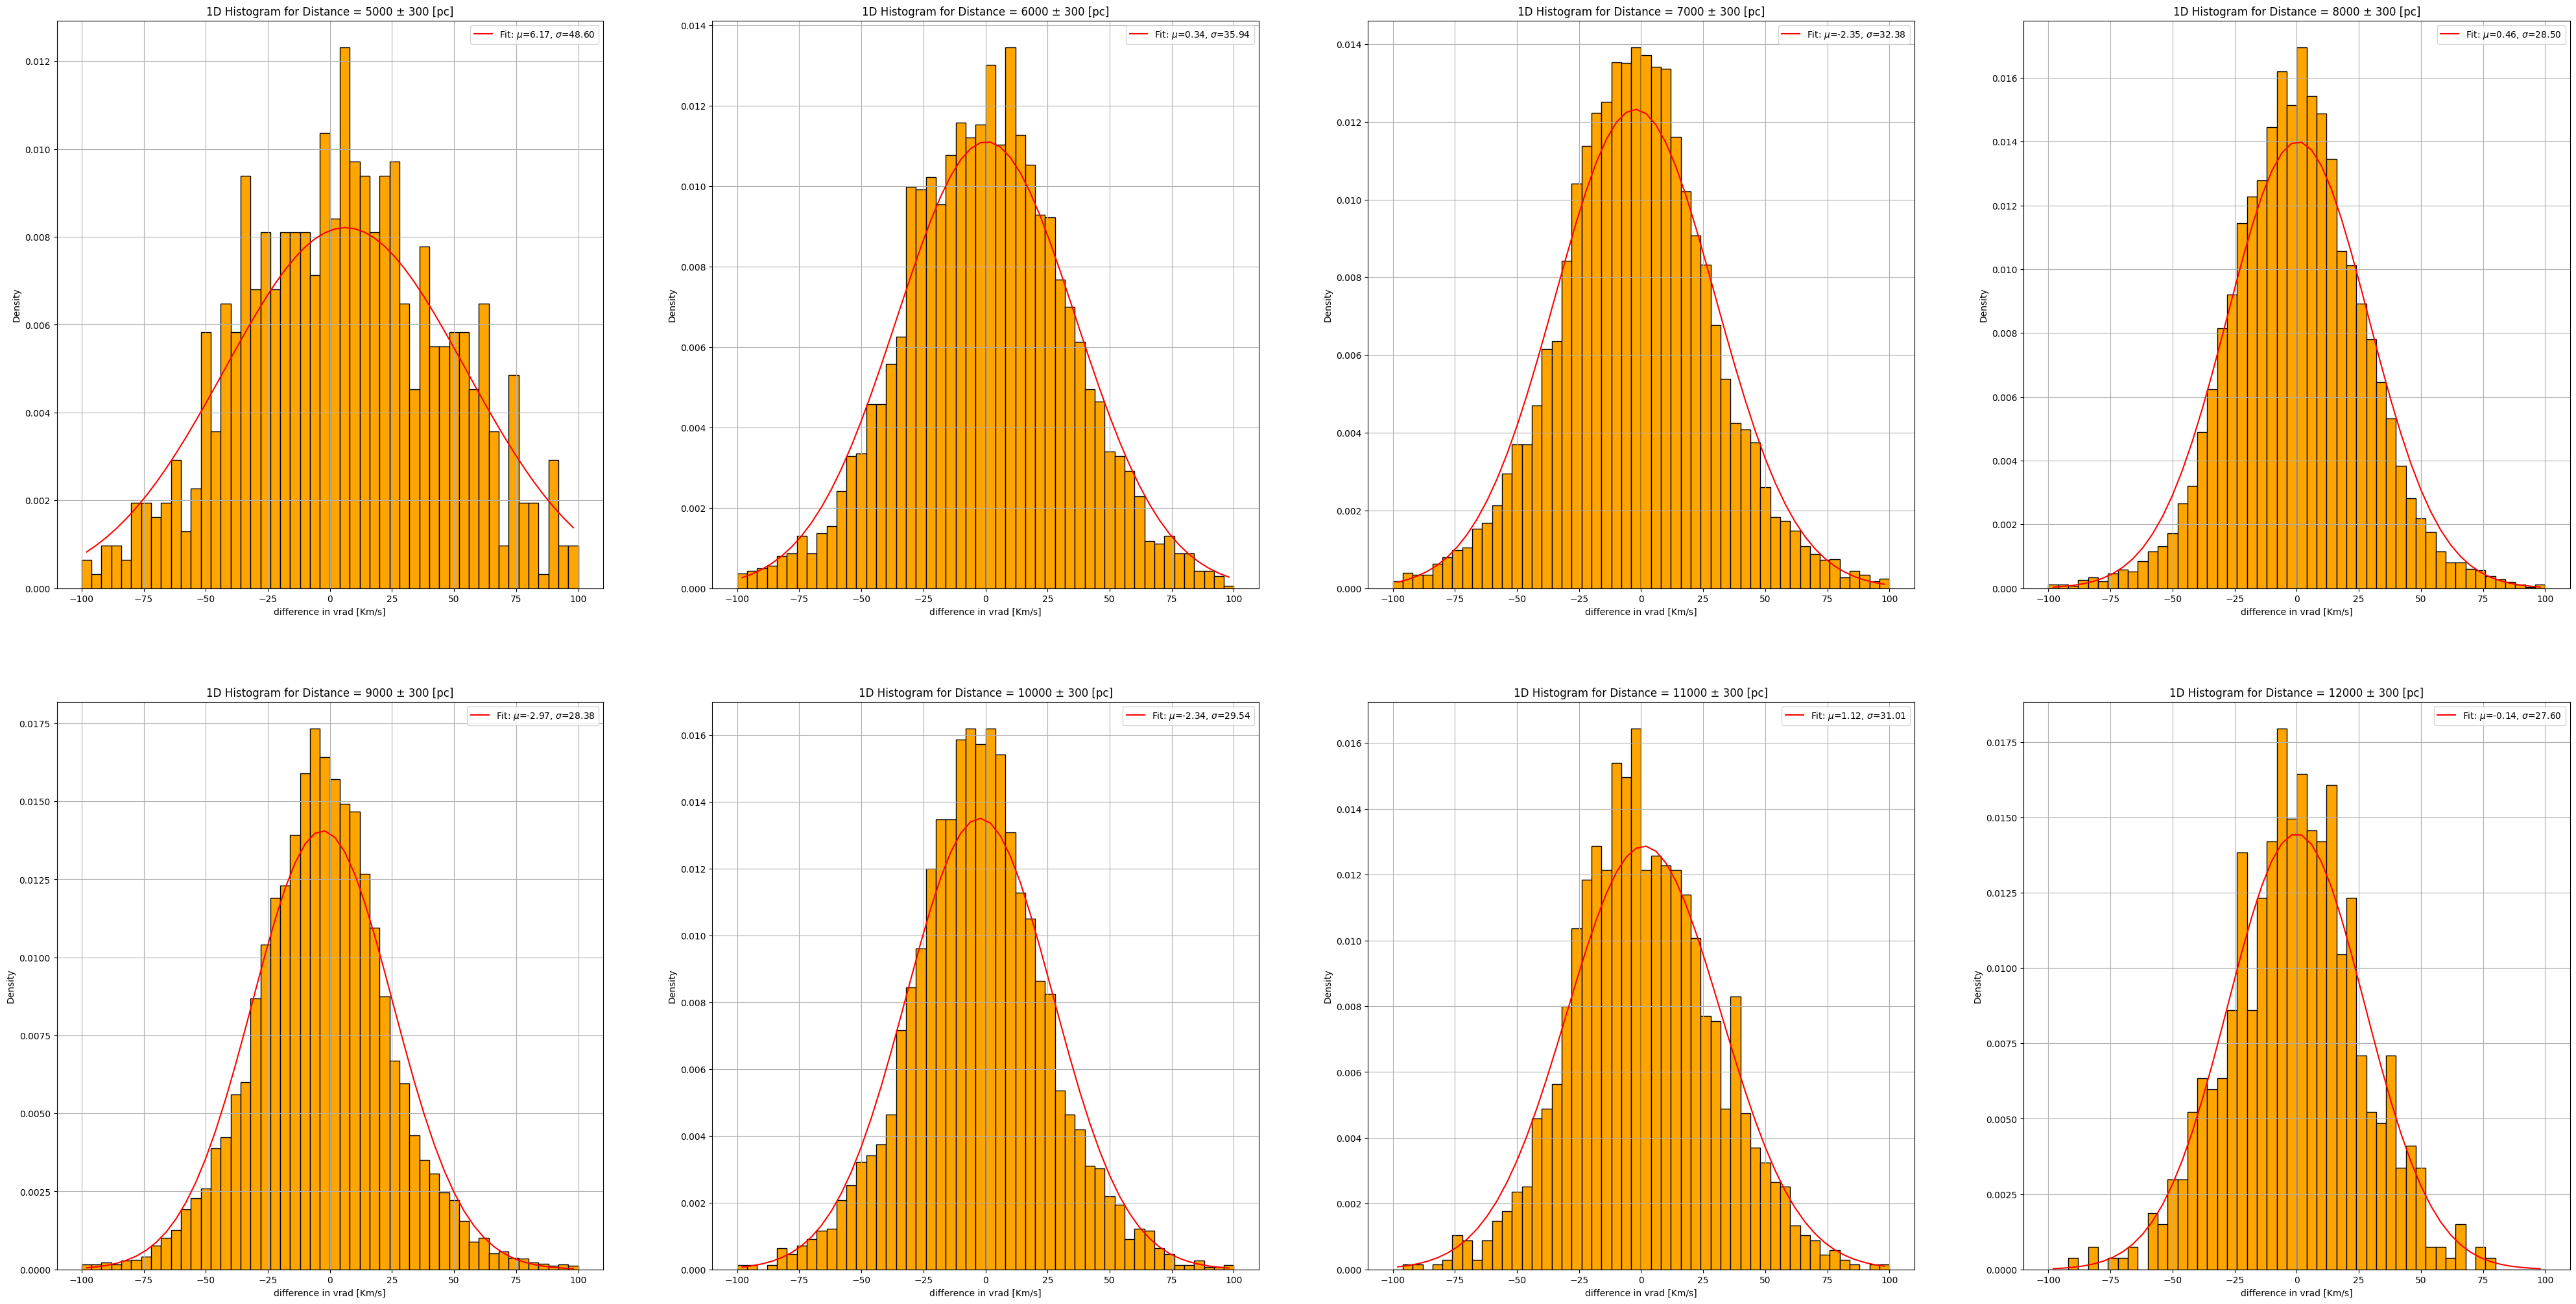

In [38]:
# plt.hist2d(df['D'], df['radial_velocity'] - df['vModTry'], bins = (100, 100), range=((5000, 12000), (-100, 100)), cmap = "inferno");
# plt.colorbar()
# plt.xlabel("distance from galactic center [pc]")
# plt.ylabel("difference in vrad [Km/s]")

# Compute the 2D histogram
hist, xedges, yedges = np.histogram2d(
    df['D'], 
    df['radial_velocity'] - df['vModTry'], 
    bins=(100, 100), 
    range=((5000, 12000), (-100, 100))
)

# Normalize each column
hist_normalized = hist / hist.sum(axis=1, keepdims=True)

# Plot the normalized histogram
plt.imshow(
    hist_normalized.T, 
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
    aspect='auto', 
    origin='lower', 
    cmap='inferno'
)
plt.colorbar(label="Normalized Count")
plt.xlabel("distance from galactic center [pc]")
plt.ylabel("difference in vrad [Km/s]")

# Filter the data for distance close to 8000 [pc]

Rows = 2
Cols = 4
fig, axs = plt.subplots(Rows, Cols, figsize = (50,25))


for i, Distance in enumerate([5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000]):
    n = i // Cols
    m = i % Cols

    distance_target = Distance
    tolerance = 300  # Define a tolerance range for filtering
    filtered_data = df[(df['D'] >= distance_target - tolerance) & (df['D'] <= distance_target + tolerance)]

    # Extract the velocity differences
    velocity_diff = filtered_data['radial_velocity'] - filtered_data['vModTry']

    # Perform Gaussian fit
    mu, sigma = norm.fit(velocity_diff)

    # Create a histogram for the velocity differences
    counts, bins, _ = axs[n, m].hist(
        velocity_diff, 
        bins=50, 
        range=(-100, 100), 
        color='orange', 
        edgecolor='black', 
        density=True  # Normalize the histogram to make it comparable to the PDF
    )

    # Plot the Gaussian fit
    bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Compute bin centers
    pdf = norm.pdf(bin_centers, mu, sigma)  # Gaussian PDF
    axs[n, m].plot(bin_centers, pdf, 'r-', label=f'Fit: $\mu$={mu:.2f}, $\sigma$={sigma:.2f}')

    # Add labels, title, and legend
    axs[n, m].set_xlabel("difference in vrad [Km/s]")
    axs[n, m].set_ylabel("Density")
    axs[n, m].set_title(f"1D Histogram for Distance = {distance_target} ± {tolerance} [pc]")
    axs[n, m].legend()
    axs[n, m].grid(True)

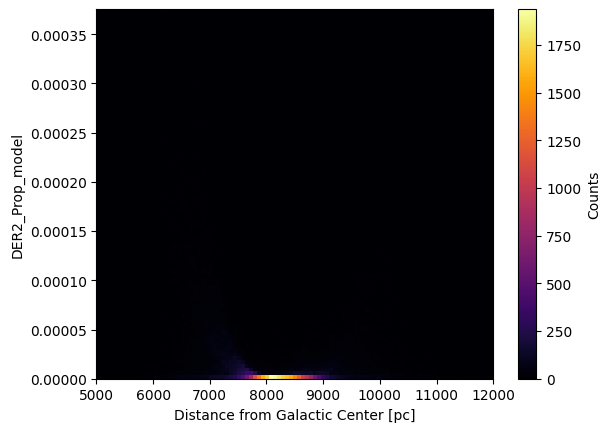

In [39]:
# check how der2propmodel varies with the distance from galactic center
# Define axis limits
x_min, x_max = 5000, 12000
y_min, y_max = 0, np.mean(df["DER2_Prop_model"])*2

# Set the number of bins for each axis
x_bins = 100  # Number of bins for the x-axis
y_bins = 100  # Number of bins for the y-axis

# Create the 2D histogram with specified bins and axis limits
plt.hist2d(
    df["D"], 
    df["DER2_Prop_model"], 
    bins=(np.linspace(x_min, x_max, x_bins), np.linspace(y_min, y_max, y_bins)), 
    cmap="inferno"
)

# Set axis limits
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))

# Add labels and colorbar
plt.xlabel("Distance from Galactic Center [pc]")
plt.ylabel("DER2_Prop_model")
plt.colorbar(label="Counts")
plt.show()

## Walkers to sample space parameter

In [ ]:
import emcee

ndim = 4  
nwalkers = 96
nsteps = 10000 
burnin = 250

# Valori iniziali casuali per i walker
p0 = np.random.randn(nwalkers, ndim) 

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(df['radial_velocity'], df['VAR_rad_vel'], df['DER2_Prop_model'], df['sinl'], df['cosl'], df['D']))

sampler.run_mcmc(p0, nsteps, progress=True)

flat_samples = sampler.get_chain(discard=burnin, thin=10, flat=True)

print("Forma dei campioni:", flat_samples.shape)

  0%|          | 0/10000 [00:00<?, ?it/s]/home/gabri/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  7%|▋         | 714/10000 [05:37<1:35:40,  1.62it/s]

plot the walkers

Text(0.5, 0, 'step number')

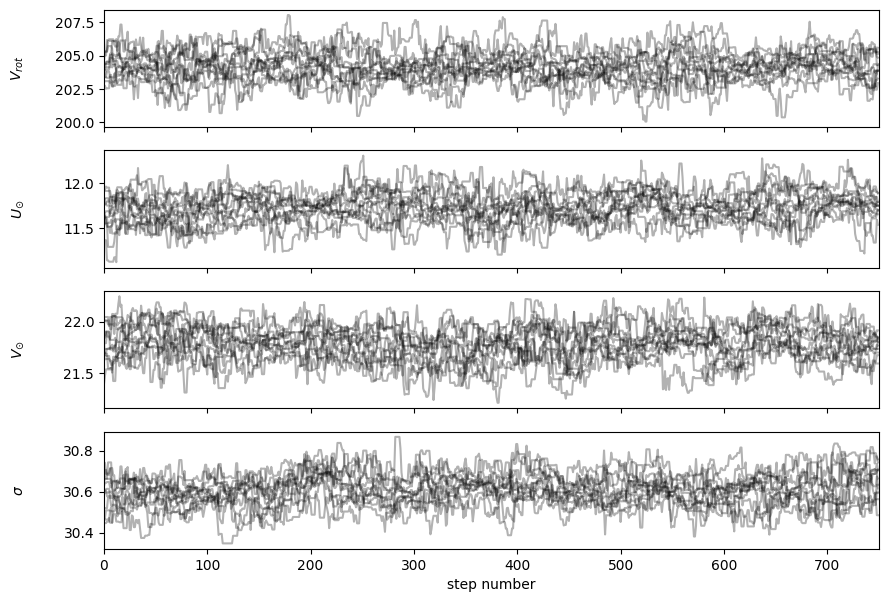

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=burnin)
labels = [r"$V_{rot}$", r"$U_{\odot}$", r"$V_{\odot}$", r"$\sigma$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

plot contour

Parameter 1: Median = 204.1544, 95% CI = [201.8910, 206.3016]
Parameter 2: Median = 11.7381, 95% CI = [11.4133, 12.0338]
Parameter 3: Median = 21.7929, 95% CI = [21.4482, 22.0795]
Parameter 4: Median = 30.6087, 95% CI = [30.4561, 30.7523]
(900, 4)


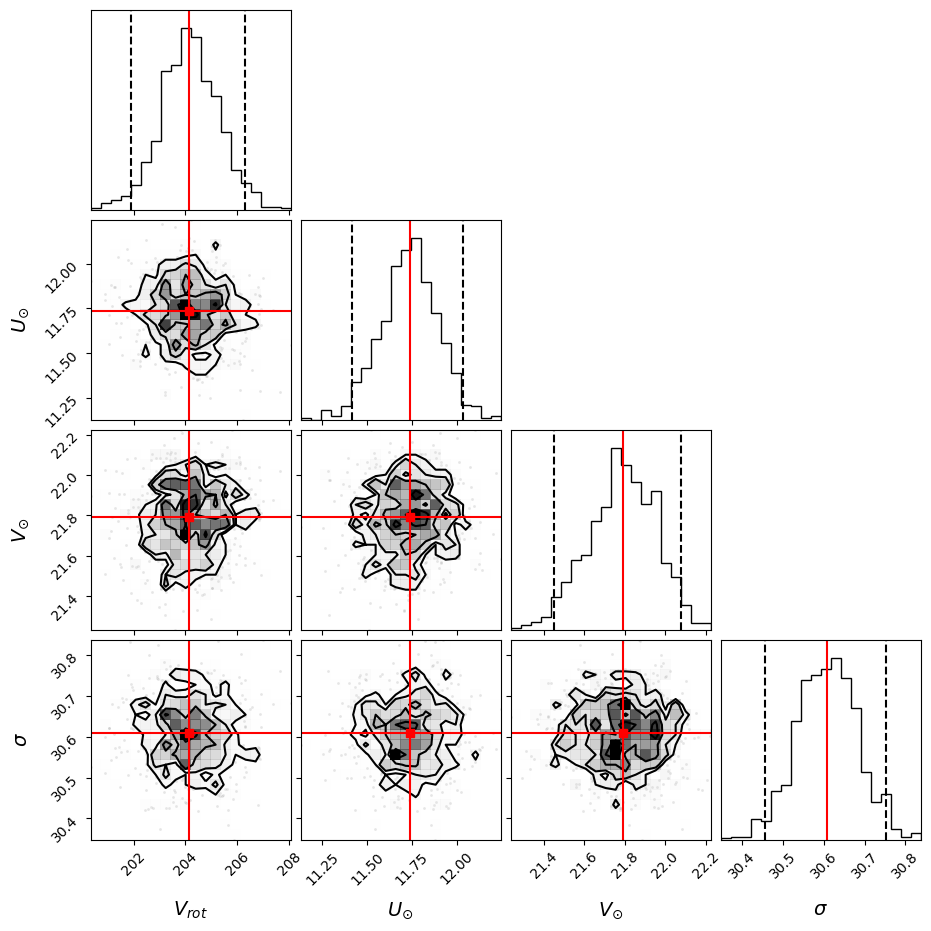

In [ ]:
import corner

# Assuming `samples` is an (N, 4) array where N is the number of samples
best_values = np.median(flat_samples, axis=0)  # Median for each parameter
credible_intervals = np.percentile(flat_samples, [2.5, 97.5], axis=0)  # 95% credible interval

# Display results
for i, (median, lower, upper) in enumerate(zip(best_values, credible_intervals[0], credible_intervals[1])):
    print(f"Parameter {i+1}: Median = {median:.4f}, 95% CI = [{lower:.4f}, {upper:.4f}]")

print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels, truths = best_values, truth_color  ="red", label_kwargs={"fontsize": 14}, quantiles=[0.025, 0.975])


